# Homework 4

## References

+ Lectures 13-16 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.

    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

## Student details

+ **First Name: Ali Ibrahim A**
+ **Last Name: Albazroun**
+ **Email: aia@illinois.edu**

# Problem 1 - Estimating the mechanical properties of a plastic material from molecular dynamics simulations

First, make sure that [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/stress_strain.txt) dataset is visible from this Jupyter notebook.
You may achieve this by either:

+ Downloading the data file and then manually upload it on Google Colab. The easiest way is to click on the folder icon on the left of the browser window and click on the upload button (or drag and drop the file). Some other options are [here](https://colab.research.google.com/notebooks/io.ipynb).
+ Downloading the file to the working directory of this notebook with this code:

In [3]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/stress_strain.txt"
download(url)

It's up to you what you choose to do.
If the file is in the right place, the following code should work:

In [4]:
data =  np.loadtxt('stress_strain.txt')

The dataset was generated using a molecular dynamics simulation of a plastic material (thanks to [Professor Alejandro Strachan](https://engineering.purdue.edu/MSE/people/ptProfile?id=33239) for sharing the data!).
Specifically, Strachan's group did the following:
- They took a rectangular chunk of the material and marked the position of each one of its atoms;
- They started applying a tensile force along one dimension.
The atoms are coupled together through electromagnetic forces, and they must all satisfy Newton's law of motion.
- For each value of the applied tensile force, they marked the stress (force be unit area) in the middle of the material and the corresponding strain of the material (percent elongation in the pulling direction).
- Eventually, the material entered the plastic regime and broke.
Here is a visualization of the data:

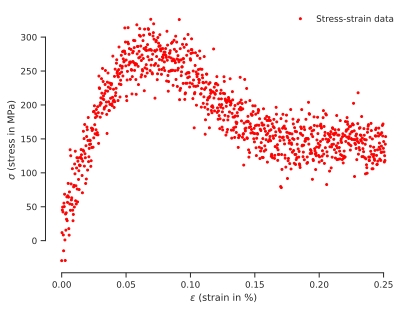

In [5]:
# Strain
x = data[:, 0]
# Stress in MPa
y = data[:, 1]

plt.figure()
plt.plot(
    x,
    y,
    'ro',
    markersize=2,
    label='Stress-strain data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Note that you don't necessarily get a unique stress for each particular value of the strain.
This is because the atoms are jiggling around due to thermal effects.
So, there is always this "jiggling" noise when measuring the stress and the strain.
We want to process this noise to extract what is known as the [stress-strain curve](https://en.wikipedia.org/wiki/Stress–strain_curve) of the material.
The stress-strain curve is a macroscopic property of the material, affected by the fine structure, e.g., the chemical bonds, the crystalline structure, any defects, etc.
It is a required input to the mechanics of materials.

## Part A - Fitting the stress-strain curve in the elastic regime
The very first part of the stress-strain curve should be linear.
It is called the *elastic regime*.
In that region, say $\epsilon < \epsilon_l=0.04$, the relationship between stress and strain is:

$$
\sigma(\epsilon) = E\epsilon.
$$

The constant $E$ is known as the *Young modulus* of the material.
Assume that you measure $\epsilon$ without noise, but your measured $\sigma$ is noisy.

### Subpart A.I
First, extract the relevant data for this problem, split it into training and validation datasets, and visualize the training and validation datasets using different colors.

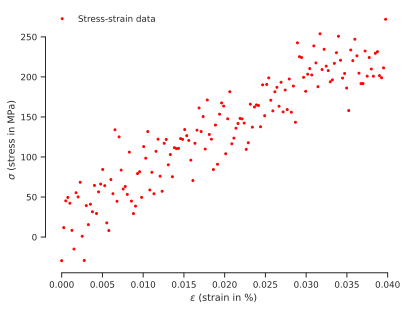

In [6]:
# The point at which the stress-strain curve stops being linear
epsilon_l = 0.04
# Relevant data (this is nice way to get the linear part of the stresses and straints)
x_rel = x[x < 0.04]
y_rel = y[x < 0.04]

# Visualize to make sure you have the right data
plt.figure()
plt.plot(
    x_rel,
    y_rel,
    'ro',
    markersize=2,
    label='Stress-strain data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Split your data into training and validation.

**Hint:** You may use [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) if you wish.

In [8]:
# Split the data into training and validation datasets
# Hint: Consult the lecture notes
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_rel, y_rel, test_size=0.33)

NameError: name 'x_rel' is not defined

Use the following to visualize your split:

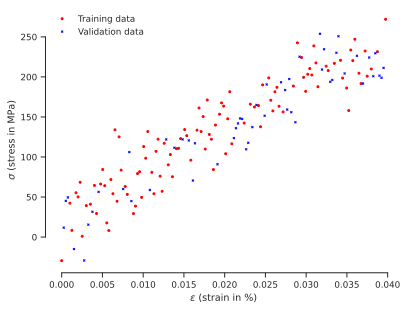

In [8]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

### Subpart A.II
Perform Bayesian linear regression with the evidence approximation to estimate the noise variance and the hyperparameters of the prior.

In [48]:
# Your code here
from sklearn.linear_model import BayesianRidge
#from lecture
def get_polynomial_design_matrix(x, degree):
    """Return the polynomial design matrix of ``degree`` evaluated at ``x``.

    Arguments:
    x      -- A 2D array with only one column.
    degree -- An integer greater than zero.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    cols = []
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

# Parameters
degree = 1 #since it is linear

# Design matrix
Phi = get_polynomial_design_matrix(x_train[:, None], degree)

# Fit
model = BayesianRidge(
    fit_intercept=False
).fit(Phi, y_train)

AssertionError: You must make x a 2D array.

### Subpart A.III
Calculate the mean square error of the validation data.

In [10]:
# your code here
Phi_valid = get_polynomial_design_matrix(x_valid[:, None], degree)

# Predict with model
y_predict, y_std = model.predict(
    Phi_valid,
    return_std=True
)
print("Mean square error of the validation data",np.sqrt(np.average((y_predict-y_valid)**2)))

28.0515335385512


### Subpart A.IV
Make the observations vs predictions plot for the validation data.

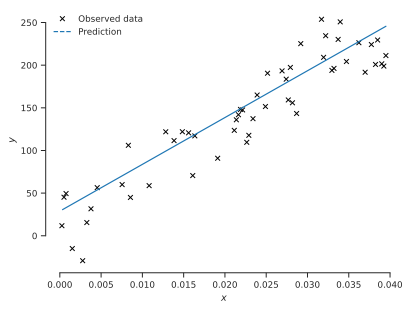

In [11]:
# your code here
# Plot
fig, ax = plt.subplots()
ax.plot(x_valid, y_valid, 'kx', label='Observed data')
ax.plot(x_valid, y_predict, "--", label="Prediction")
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Subpart A.V
Compute and plot the standardized errors for the validation data.

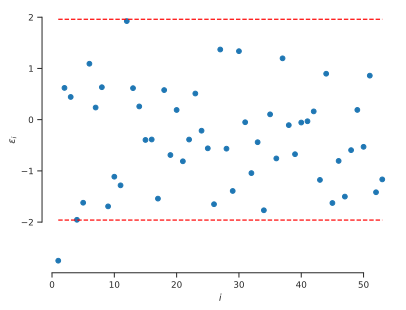

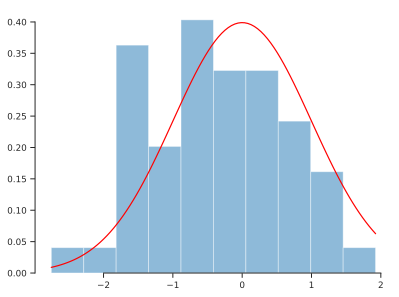

In [12]:
# your code here
eps = (y_valid - y_predict) / y_std
idx = np.arange(1, eps.shape[0] + 1)

fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$')
sns.despine(trim=True);
import scipy.stats as st

fig, ax = plt.subplots()
ax.hist(eps, alpha=0.5, density=True)
ee = np.linspace(eps.min(), eps.max(), 100)
ax.plot(ee, st.norm.pdf(ee), 'r')
sns.despine(trim=True);

### Subpart A.VI
Make the quantile-quantile plot of the standardized errors.

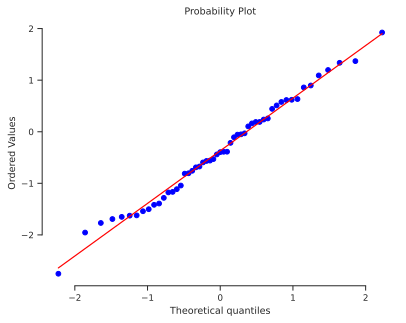

In [13]:
# your code here
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax)
sns.despine(trim=True);

### Subpart A.VII
Visualize your epistemic and the aleatory uncertainty about the stress-strain curve in the elastic regime.

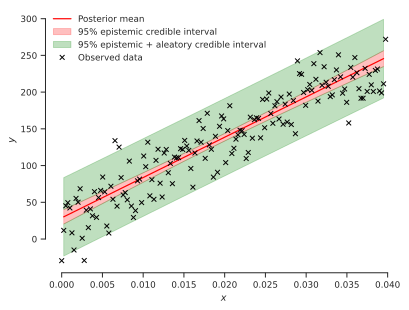

In [14]:
# your code here
def plot_posterior_predictive(
    model,
    x_observed,
    y_observed,
    xx,
    phi_func,
    phi_func_args=(),

):
    """Plot the posterior predictive separating
    aleatory and espitemic uncertainty.

    Arguments:
    model    -- A trained model.
    x_observed -- The obsevation x coordinates
    y_observed -- The obsevation y coordinates
    xx       -- The points on which to evaluate
                the posterior predictive.
    phi_func -- The function to use to compute
                the design matrix.

    Keyword Arguments:
    phi_func_args -- Any arguments passed to the
                     function that calculates the
                     design matrix.
    """
    Phi_xx = phi_func(
        xx[:, None],
        *phi_func_args
    )
    yy_mean, yy_measured_std = model.predict(
        Phi_xx,
        return_std=True
    )
    sigma = np.sqrt(1.0 / model.alpha_)
    yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
    yy_le = yy_mean - 2.0 * yy_std
    yy_ue = yy_mean + 2.0 * yy_std
    yy_lae = yy_mean - 2.0 * yy_measured_std
    yy_uae = yy_mean + 2.0 * yy_measured_std

    fig, ax = plt.subplots()
    ax.plot(xx, yy_mean, 'r', label="Posterior mean")
    sort_idx = np.argsort(xx) #need this to make it fill the entire range instead of first and last x values in array
    ax.fill_between(
        xx[sort_idx],
        yy_le[sort_idx],
        yy_ue[sort_idx],
        color='red',
        alpha=0.25,
        label="95% epistemic credible interval"
    )
    ax.fill_between(
        xx[sort_idx],
        yy_lae[sort_idx],
        yy_le[sort_idx],
        color='green',
        alpha=0.25,
    )
    ax.fill_between(
        xx[sort_idx],
        yy_ue[sort_idx],
        yy_uae[sort_idx],
        color='green',
        alpha=0.25,
        label="95% epistemic + aleatory credible interval"
    )
    ax.plot(x_observed, y_observed, 'kx', label='Observed data')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plt.legend(loc="best", frameon=False)
    sns.despine(trim=True);


plot_posterior_predictive(
    model,
    x_rel,
    y_rel,
    x_valid,
    get_polynomial_design_matrix,
    phi_func_args=(degree,),
)


### Subpart A. VIII
Visualize the posterior of the Young modulus E conditioned on the data.

Posterior mean w: [  30.36232645 5187.27917622]
Posterior covariance w:
[[ 3.87204554e-04 -1.42452081e-02]
 [-1.42452081e-02  6.92899252e-01]]


Text(0.5, 1.0, "Posterior of the Young's modulus E")

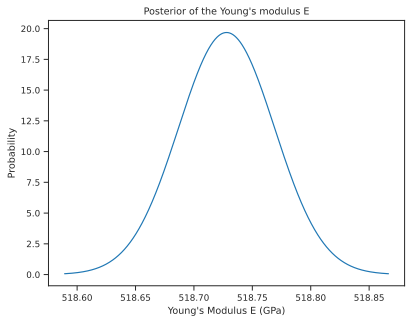

In [109]:
# your code here
def find_m_and_S(Phi, y, sigma2, alpha):
    """Return the posterior mean and covariance of the weights
    of a Bayesian linear regression problem.

    Arguments:
    Phi    -- The design matrix.
    y      -- The observed targets.
    sigma2 -- The noise variance.
    alpha  -- The prior weight precision.
    """
    A = (
        Phi.T @ Phi / sigma2
        + alpha * np.eye(Phi.shape[1])
    )
    L = scipy.linalg.cho_factor(A)
    m = scipy.linalg.cho_solve(
        L,
        Phi.T @ y / sigma2
    )
    S = scipy.linalg.cho_solve(
        L,
        np.eye(Phi.shape[1])
    )
    return m, S
sigma2 = 0.1 ** 2
alpha = 0.01

# Here is the prior for the weights as a distribution:
w_prior = st.multivariate_normal(
    mean=np.zeros(degree+1),
    cov=np.eye(degree+1) / alpha
)

# Get the posterior mean and covariance for the weights:
m, S = find_m_and_S(Phi, y_train, sigma2, alpha)
# The posterior of the weights as a distribution:
w_post = st.multivariate_normal(mean=m, cov=S)
print(f"Posterior mean w: {m}")
print("Posterior covariance w:")
print(S)
x = np.linspace(m[1]-2*S[1,1],m[1]+2*S[1,1],1000)
y = np.zeros_like(x)
for i,j in enumerate(x):
  y[i] = w_post.pdf(np.array([m[0],j]))
plt.plot(x/10,y) #since the x represents the slope it has units of MPa/% = 0.01MPa, dividing by 10 will convert it to GPa
plt.xlabel("Young's Modulus E (GPa)")
plt.ylabel("Probability")
plt.title("Posterior of the Young's modulus E")

### Subpart A.IX
Take five samples of stress-strain curve in the elastic regime and visualize them.

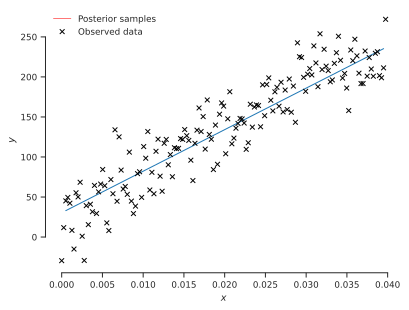

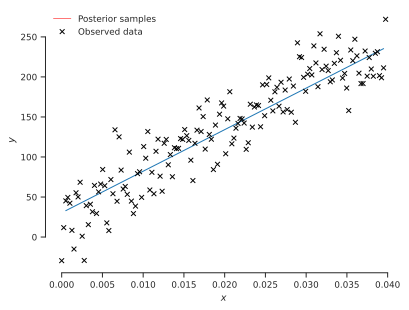

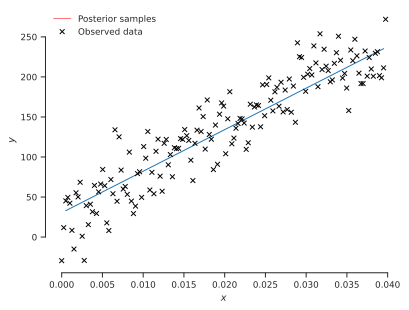

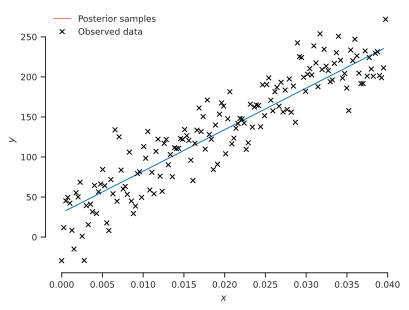

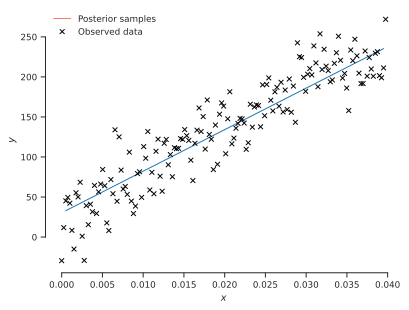

In [107]:
# your code here

for _ in range(5):
    # Here is how you can sample from the posterior
    fig, ax = plt.subplots()
    w_sample = w_post.rvs()
    yy_sample = np.dot(Phi, w_sample)
    ax.plot(x_train, yy_sample, lw=1)
    ax.plot([], [], 'r', lw=0.5, label="Posterior samples")
    ax.plot(x_rel, y_rel, 'kx', label='Observed data')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plt.legend(loc="best", frameon=False)
    sns.despine(trim=True)

### Subpart A.X

Find the 95% centered credible interval for the Young modulus $E$.

In [ ]:
# your code here
E =
theta_low = Theta_post.ppf(0.025)
theta_up = Theta_post.ppf(0.975)
print(f'Theta is in [{theta_low:.2f}, {theta_up:1.2f}] with 95% probability')

### Subpart A.XI
If you had to pick a single value for the Young modulus $E$, what would it be and why?

In [ ]:
# your code here

*Your answer here*

## Part B - Estimate the ultimate strength

The pick of the stress-strain curve is known as the ultimate strength.
We want to estimate it.

### Subpart B.I - Extract training and validation data

Extract training and validation data from the entire dataset.

In [15]:
# your code here - Repeat as many text and code blocks as you like
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33)

Use the following to visualize your split:

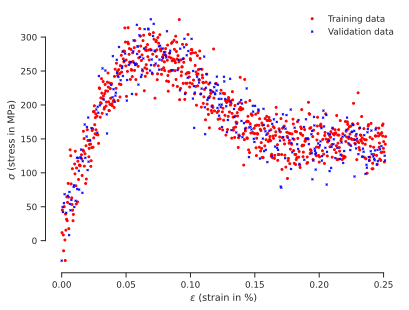

In [16]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

### Subpart B.II - Model the entire stress-strain relationship.
To do this, we will set up a generalized linear model to capture the entire stress-strain relationship.
Remember, you can use any model you want as soon as:
+ It is linear in the parameters to be estimated,
+ It has a well-defined elastic regime (see Part A).

I am going to help you set up the right model.
We will use the [Heavide step function](https://en.wikipedia.org/wiki/Heaviside_step_function) to turn on or off models for various ranges of $\epsilon$. The idea is quite simple: We will use a linear model for the elastic regime, and we are going to turn to a non-linear model for the non-linear regime.
Here is a model that has the right form in the elastic regime and an arbitrary form in the non-linear regime:

$$
f(\epsilon;E,\mathbf{w}_g) = E\epsilon \left[(1 - H(\epsilon - \epsilon_l)\right] + g(\epsilon;\mathbf{w}_g)H(\epsilon - \epsilon_l),
$$

where

$$
H(x) = \begin{cases}
0,\;\text{if}\;x < 0\\
1,\;\text{otherwise},
\end{cases}
$$

and $g$ is any function linear in the parameters $\mathbf{w}_g$.

You can use any model you like for the non-linear regime, but let's use a polynomial of degree $d$:

$$
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i.
$$

The full model can be expressed as:

$$
\begin{split}
f(\epsilon) &=
\begin{cases}
h(\epsilon) = E \epsilon,\ \epsilon < \epsilon_l, \\
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i, \epsilon \geq \epsilon_l
\end{cases}\\
&= E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
\end{split}
$$

We could proceed with this model, but there is a small problem: It is discontinuous at $\epsilon = \epsilon_l$.
This is unphysical. We can do better than that!

To make the model nice, we force the $h$ and $g$ to match up to the first derivative, i.e., we demand that:

$$
\begin{split}
h(\epsilon_l) &= g(\epsilon_l)\\
h'(\epsilon_l) &= g'(\epsilon_l).
\end{split}
$$

We include the first derivative because we don't have a kink in the stress-strain. That would also be unphysical.
The two equations above become:

$$
\begin{split}
E\epsilon_l &= \sum_{i=0}^dw_i\epsilon_l^i\\
E &= \sum_{i=1}^diw_i\epsilon_l^{i-1}.
\end{split}
$$

We can use these two equations to eliminate two weights.
Let's eliminate $w_0$ and $w_1$.
All you have to do is express them in terms of $E$ and $w_2,\dots,w_d$.
So, there remain $d$ parameters to estimate.
Let's get back to the stress-strain model.

Our stress-strain model was:

$$
f(\epsilon) = E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
$$

We can now use the expressions for $w_0$ and $w_1$ to rewrite this using only all the other
parameters.
I am going to spare you the details.
The result is:

$$
f(\epsilon) = E\epsilon + \sum_{i=2}^dw_i\left[(i-1)\epsilon_{l}^{i} - i \epsilon \epsilon_{l}^{i-1} + \epsilon^i\right]H(\epsilon - \epsilon_l).
$$

Okay.
This is still a generalized linear model. This is nice.
Write code for the design matrix:

In [ ]:
# Complete this code to make your model:
def compute_design_matrix(Epsilon, epsilon_l, d):
    """Compute the design matrix for the stress-strain curve problem.

    Arguments:
        Epsilon     -     A 1D array of dimension N.
        epsilon_l   -     The strain signifying the end of the elastic regime.
        d           -     The polynomial degree.

    Returns:
        A design matrix N x d
    """
    # Sanity check
    assert isinstance(Epsilon, np.ndarray)
    assert Epsilon.ndim == 1, 'Pass the array as epsilon.flatten(), if it is two dimensional'
    n = Epsilon.shape[0]
    # The design matrix:
    Phi = np.ndarray((n, d))
    # The step function evaluated at all the elements of Epsilon.
    # You can use it if you want.
    Step = np.ones(n)
    Step[Epsilon < epsilon_l] = 0
    # Build the design matrix
    Phi[:, 0] = # Your code here
    for i in range(2, d+1):
        Phi[:, i-1] = # Your code here
    return Phi

Visualize the basis functions here:

In [ ]:
d = 4
eps = np.linspace(0, x.max(), 100)
Phis = compute_design_matrix(eps, epsilon_l, d)
fig, ax = plt.subplots(dpi=100)
ax.plot(eps, Phis)
ax.set_xlabel('$\epsilon$ (strain in %))')
ax.set_ylabel('$\phi_i(\epsilon)$')
sns.despine(trim=True);

### Subpart B.III

Fit the model using automatic relevance determination and demonstrate that it works well by doing everything we did above (MSE, observations vs. predictions plot, standardized errors, etc.).

In [ ]:
# Your code here - Use as many blocks as you need!
model = # Just call the resulting model "model"

### Subpart B.IV
Visualize the epistemic and aleatory uncertainty in the stess-strain relation.

In [ ]:
# Your code here

### Subpart B.V - Extract the ultimate strength

Now, you will quantify your epistemic uncertainty about the ultimate strength.
The ultimate strength is the maximum of the stress-strain relationship.
Since you have epistemic uncertainty about the stress-strain relationship, you also have epistemic uncertainty about the ultimate strength.

Do the following:
- Visualize the posterior of the ultimate strength.
- Find a 95% credible interval for the ultimate strength.
- Pick a value for the ultimate strength.

**Hint:**
To characterize your epistemic uncertainty about the ultimate strength, you would have to do the following:
- Define a dense set of strain points between 0 and 0.25.
- Repeatedly:
 + Sample from the posterior of the weights of your model
 + For each sample, evaluate the stresses at the dense set of strain points defined earlier
 + For each sampled stress vector, find the maximum. This is a sample of the ultimate strength.

In [ ]:
# Enter your code here

# Problem 2 - Optimizing the performance of a compressor

In this problem, we will need [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/compressor_data.xlsx) dataset. The dataset was kindly provided to us by [Professor Davide Ziviani](https://scholar.google.com/citations?user=gPdAtg0AAAAJ&hl=en).
As before, you can either put it on your Google Drive or just download it with the code segment below:

In [3]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/compressor_data.xlsx"
download(url)

Note that this is an Excel file, so we need pandas to read it.
Here is how:

In [4]:
import pandas as pd
data = pd.read_excel('compressor_data.xlsx')
data

,T_e,DT_sh,T_c,DT_sc,T_amb,f,m_dot,m_dot.1,Capacity,Power,Current,COP,Efficiency
0,-30,11,25,8,35,60,28.8,8.000000,1557,901,4.4,1.73,0.467
1,-30,11,30,8,35,60,23.0,6.388889,1201,881,4.0,1.36,0.425
2,-30,11,35,8,35,60,17.9,4.972222,892,858,3.7,1.04,0.382
3,-25,11,25,8,35,60,46.4,12.888889,2509,1125,5.3,2.23,0.548
4,-25,11,30,8,35,60,40.2,11.166667,2098,1122,5.1,1.87,0.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,10,11,45,8,35,60,245.2,68.111111,12057,2525,11.3,4.78,0.722
61,10,11,50,8,35,60,234.1,65.027778,10939,2740,12.3,3.99,0.719
62,10,11,55,8,35,60,222.2,61.722222,9819,2929,13.1,3.35,0.709
63,10,11,60,8,35,60,209.3,58.138889,8697,3091,13.7,2.81,0.693


The data are part of an experimental study of a variable-speed reciprocating compressor.
The experimentalists varied two temperatures, $T_e$ and $T_c$ (both in C), and they measured various other quantities.
We aim to learn the map between $T_e$ and $T_c$ and measure Capacity and Power (both in W).
First, let's see how you can extract only the relevant data.

In [5]:
# Here is how to extract the T_e and T_c columns and put them in a single numpy array
x = data[['T_e','T_c']].values
x

array([[-30,  25],
       [-30,  30],
       [-30,  35],
       [-25,  25],
       [-25,  30],
       [-25,  35],
       [-25,  40],
       [-25,  45],
       [-20,  25],
       [-20,  30],
       [-20,  35],
       [-20,  40],
       [-20,  45],
       [-20,  50],
       [-15,  25],
       [-15,  30],
       [-15,  35],
       [-15,  40],
       [-15,  45],
       [-15,  50],
       [-15,  55],
       [-10,  25],
       [-10,  30],
       [-10,  35],
       [-10,  40],
       [-10,  45],
       [-10,  50],
       [-10,  55],
       [-10,  60],
       [ -5,  25],
       [ -5,  30],
       [ -5,  35],
       [ -5,  40],
       [ -5,  45],
       [ -5,  50],
       [ -5,  55],
       [ -5,  60],
       [ -5,  65],
       [  0,  25],
       [  0,  30],
       [  0,  35],
       [  0,  40],
       [  0,  45],
       [  0,  50],
       [  0,  55],
       [  0,  60],
       [  0,  65],
       [  5,  25],
       [  5,  30],
       [  5,  35],
       [  5,  40],
       [  5,  45],
       [  5,

In [6]:
# Here is how to extract the Capacity
y = data['Capacity'].values
y

array([ 1557,  1201,   892,  2509,  2098,  1726,  1398,  1112,  3684,
        3206,  2762,  2354,  1981,  1647,  5100,  4547,  4019,  3520,
        3050,  2612,  2206,  6777,  6137,  5516,  4915,  4338,  3784,
        3256,  2755,  8734,  7996,  7271,  6559,  5863,  5184,  4524,
        3883,  3264, 10989, 10144,  9304,  8471,  7646,  6831,  6027,
        5237,  4461, 13562, 12599, 11633, 10668,  9704,  8743,  7786,
        6835,  5891, 16472, 15380, 14279, 13171, 12057, 10939,  9819,
        8697,  7575])

Fit the following multivariate polynomial model to **both the Capacity and the Power**:

$$
y = w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2 + w_7 T_e^2T_c + w_8T_eT_c^2 + w_9 T_e^3 + w_{10}T_c^3 + \epsilon,
$$

where $\epsilon$ is a Gaussian noise term with unknown variance.

**Hints:**
+ You may use [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to construct the design matrix of your polynomial features. Do not program the design matrix by hand.
+ You should split your data into training and validation and use various validation metrics to ensure your models make sense.
+ Use [ARD Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression) to fit any hyperparameters and the noise.

## Part A - Fit the capacity

### Subpart A.I

Please don't just fit. Split in training and test and use all the usual diagnostics.

## Spliting

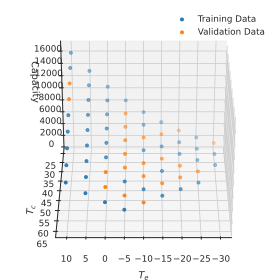

In [47]:
# your code here - Repeat as many text and code blocks as you like
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=90, roll=0)
plt.scatter(x=x_train[:,0],y=x_train[:,1],zs=y_train,s=10,marker="o",label="Training Data")
plt.scatter(x=x_valid[:,0],y=x_valid[:,1],zs=y_valid,s=10,marker="o",label="Validation Data")
ax.set_xlabel('$T_e$')
ax.set_ylabel('$T_c$')
ax.set_zlabel('Capacity')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);


## Fitting

In [55]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
# Design matrix
poly = PolynomialFeatures(3)
X_train = poly.fit_transform(x_train)

# Fit
model = linear_model.ARDRegression().fit(X_train, y_train)

In [56]:
# your code here
X_valid = poly.fit_transform(x_valid)

# Predict with model
y_predict, y_std = model.predict(
    X_valid,
    return_std=True
)
print("Mean square error of the validation data",np.sqrt(np.average((y_predict-y_valid)**2)))

Mean square error of the validation data 3.2486319850117718


## Predictions vs observations

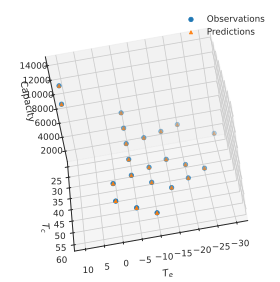

In [61]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=90, roll=10)
plt.scatter(x=x_valid[:,0],y=x_valid[:,1],zs=y_valid,s=20,marker="o",label="Observations")
plt.scatter(x=x_valid[:,0],y=x_valid[:,1],zs=y_predict,s=10,marker='^',label="Predictions")
ax.set_xlabel('$T_e$')
ax.set_ylabel('$T_c$')
ax.set_zlabel('Capacity')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Standardized errors

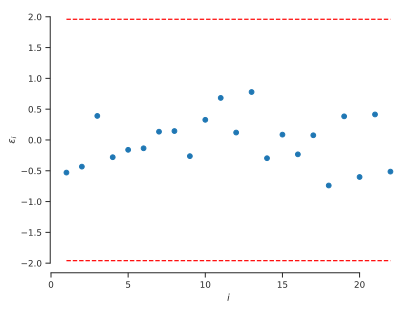

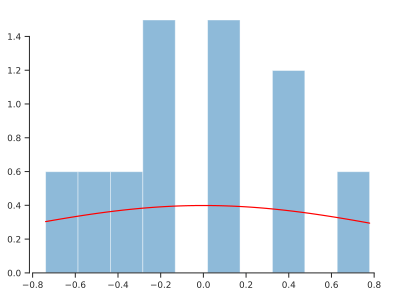

In [58]:
# your code here
eps = (y_valid - y_predict) / y_std
idx = np.arange(1, eps.shape[0] + 1)

fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$')
sns.despine(trim=True);
import scipy.stats as st

fig, ax = plt.subplots()
ax.hist(eps, alpha=0.5, density=True)
ee = np.linspace(eps.min(), eps.max(), 100)
ax.plot(ee, st.norm.pdf(ee), 'r')
sns.despine(trim=True);

## Quantile-quantile plot for standardized errors

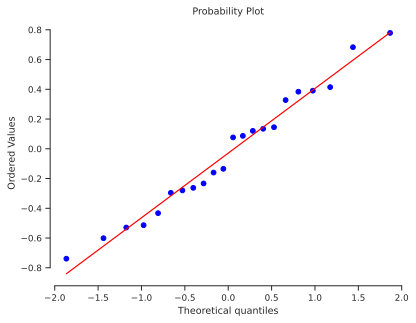

In [59]:
# your code here
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax)
sns.despine(trim=True);

### Subpart A.II

What is the noise variance you estimated for the Capacity?

In [73]:
# your code here
model.__dict__

{'max_iter': 300,
 'tol': 0.001,
 'fit_intercept': True,
 'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'compute_score': False,
 'threshold_lambda': 10000.0,
 'copy_X': True,
 'verbose': False,
 'n_features_in_': 10,
 'X_offset_': array([ 1.00000000e+00, -5.11627907e+00,  4.17441860e+01,  1.81395349e+02,
        -1.61046512e+02,  1.91104651e+03, -3.49418605e+03,  6.66569767e+03,
        -4.93895349e+03,  9.45494186e+04]),
 'X_scale_': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'scores_': [],
 'n_iter_': 13,
 'coef_': array([ 0.00000000e+00,  5.76058721e+02, -1.80831446e+02,  7.42137036e+00,
        -3.07455183e+00,  1.94084449e-01,  2.51194432e-02, -4.26900764e-02,
        -2.69099464e-02,  0.00000000e+00]),
 'alpha_': np.float64(0.10771358571739825),
 'sigma_': array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        

### Subpart A.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Capacity?

The most important one will be the one coefficient with the largest (absolute value) weight in the regression model

In [71]:
# your code here
max_weight_idx = np.argmax(abs(model.coef_))
print(poly.get_feature_names_out()[max_weight_idx])

x0


$T_e$ ($x_0$) is the most important basis

## Part B - Fit the Power

### Subpart B.I

Please don't just fit. Split in training and test and use all the usual diagnostics.

In [ ]:
y = data['power'].values

### Subpart B.II

What is the noise variance you estimated for the Power?

In [ ]:
# your code here

### Subpart B.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Power?

In [ ]:
# your code here

# Problem 3 - Explaining the Challenger disaster
On January 28, 1986, the [Space Shuttle Challenger](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster) disintegrated after 73 seconds from launch.
The failure can be traced to the rubber O-rings, which were used to seal the joints of the solid rocket boosters (required to force the hot, high-pressure gases generated by the burning solid propellant through the nozzles, thus producing thrust).

The performance of the O-ring material was sensitive to the external temperature during launch.
This [dataset](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/challenger_data.csv) contains records of different experiments with O-rings recorded at various times between 1981 and 1986.
Download the data the usual way (either put them on Google Drive or run the code cell below).

In [1]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/challenger_data.csv"
download(url)

NameError: name 'download' is not defined

Even though this is a CSV file, you should load it with pandas because it contains some special characters.

In [ ]:
raw_data = pd.read_csv('challenger_data.csv')
raw_data

The first column is the date of the record. The second column is the external temperature of that day in degrees F.
The third column labeled ``Damage Incident`` has a binary coding (0=no damage, 1=damage).
The very last row is the day of the Challenger accident.

We will use the first 23 rows to solve a binary classification problem that will give us the probability of an accident conditioned on the observed external temperature in degrees F. Before proceeding to the data analysis, let's clean the data up.

First, we drop all the bad records:

In [ ]:
clean_data_0 = raw_data.dropna()
clean_data_0

We also don't need the last record. Remember that the temperature on the day of the Challenger accident was 31 degrees F.

In [ ]:
clean_data = clean_data_0[:-1]
clean_data

Let's extract the features and the labels:

In [ ]:
x = clean_data['Temperature'].values
x

In [ ]:
y = clean_data['Damage Incident'].values.astype(np.float)
y

## Part A - Perform logistic regression

Perform logistic regression between the temperature ($x$) and the damage label ($y$).
Refrain from validating because there is little data.
Just use a simple model so that you don't overfit.

In [ ]:
# your code here - Repeat as many text and code blocks as you like

## Part B - Plot the probability of damage as a function of temperature
Plot the probability of damage as a function of temperature.

In [ ]:
# your code here

## Part C - Decide whether or not to launch

The temperature on the day of the Challenger accident was 31 degrees F.
Start by calculating the probability of damage at 31 degrees F.
Then, use formal decision-making (i.e., define a cost matrix and make decisions by minimizing the expected loss) to decide whether or not to launch on that day.
Also, plot your optimal decision as a function of the external temperature.

In [ ]:
# your code here - Repeat as many text and code blocks as you like